In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import shutil
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Xem các ảnh trong thư mục frames

In [2]:
# Đường dẫn đến thư mục frames
frames_dir = Path('frames')
image_files = sorted(frames_dir.glob('frame_*.png'))

print(f"Tổng số ảnh: {len(image_files)}")
print(f"Ảnh đầu tiên: {image_files[0].name}")
print(f"Ảnh cuối cùng: {image_files[-1].name}")

Tổng số ảnh: 886
Ảnh đầu tiên: frame_0001.png
Ảnh cuối cùng: frame_0886.png


## 2. Xem một số ảnh mẫu

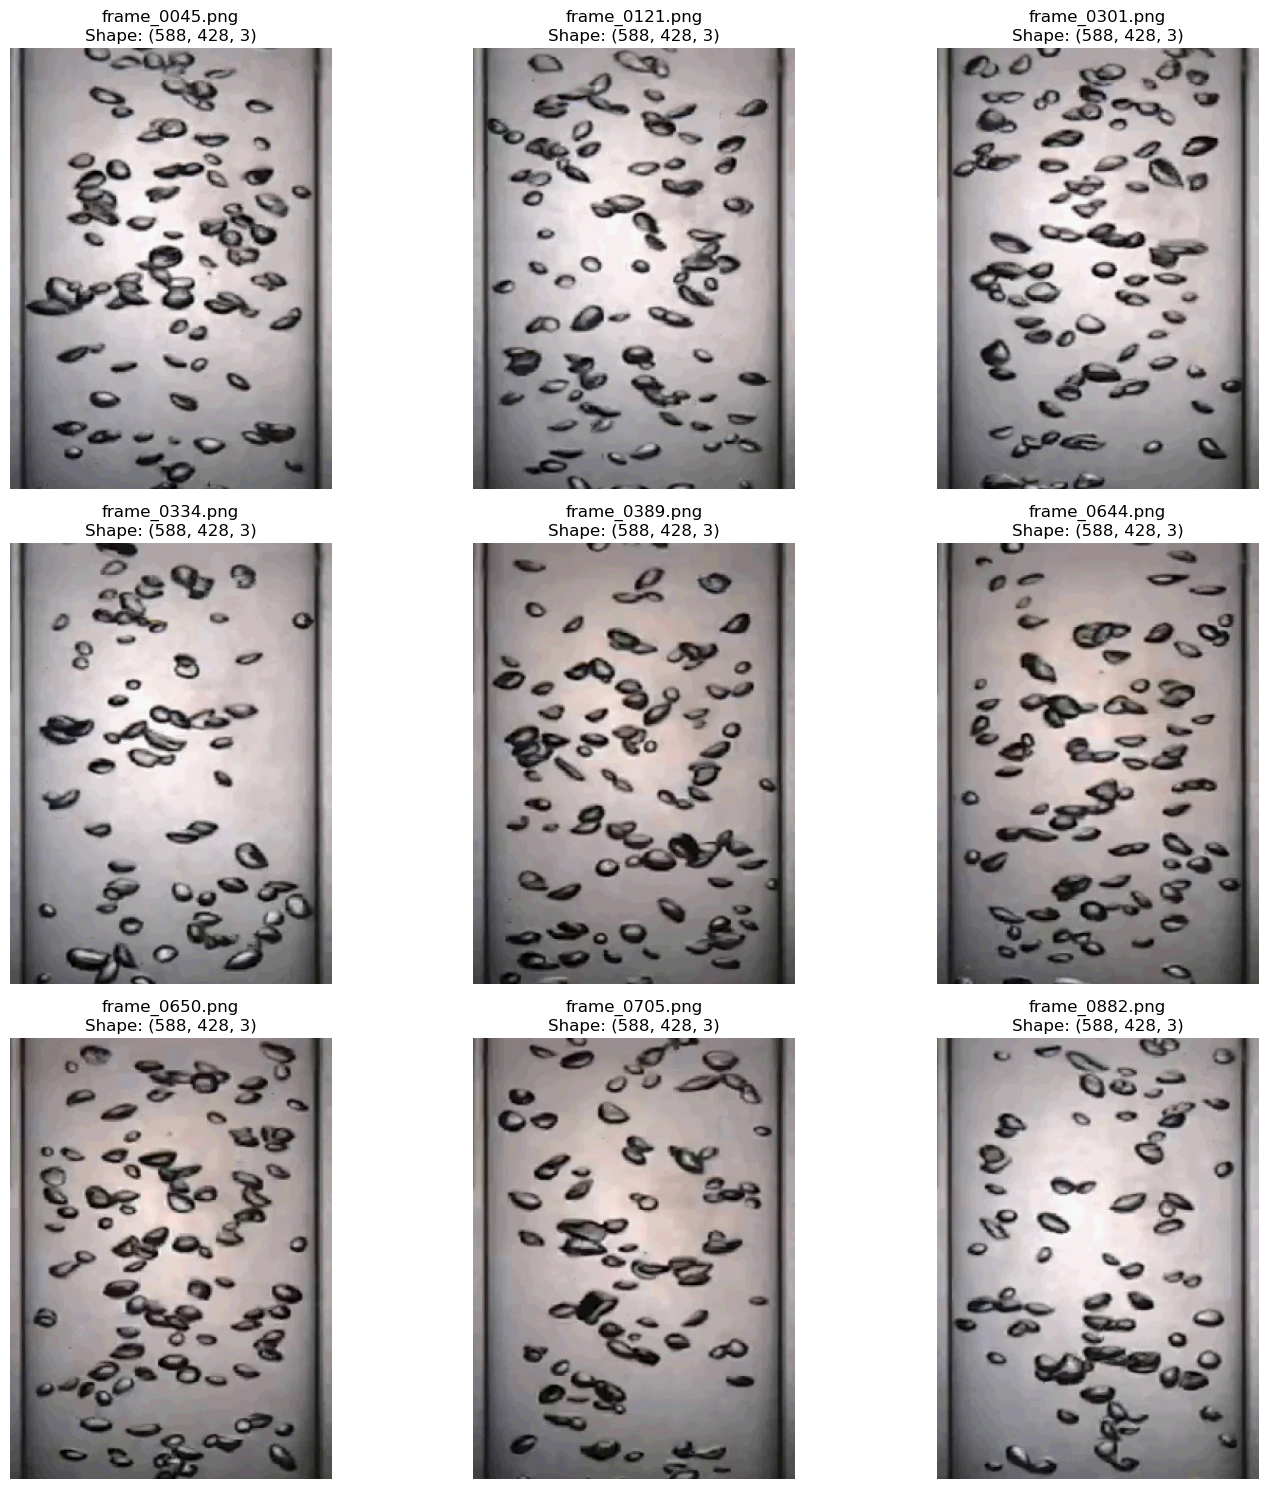


=== THÔNG TIN ẢNH ===
Shape: (588, 428, 3)
Dtype: uint8
Min value: 0
Max value: 255
Mean value: 153.74


In [3]:
# Xem 9 ảnh mẫu ngẫu nhiên
np.random.seed(42)
sample_indices = np.random.choice(len(image_files), min(9, len(image_files)), replace=False)
sample_files = [image_files[i] for i in sorted(sample_indices)]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for idx, (ax, img_path) in enumerate(zip(axes.flat, sample_files)):
    img = np.array(Image.open(img_path))
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.set_title(f"{img_path.name}\nShape: {img.shape}")
    ax.axis('off')
plt.tight_layout()
plt.show()

print("\n=== THÔNG TIN ẢNH ===")
first_img = np.array(Image.open(image_files[0]))
print(f"Shape: {first_img.shape}")
print(f"Dtype: {first_img.dtype}")
print(f"Min value: {first_img.min()}")
print(f"Max value: {first_img.max()}")
print(f"Mean value: {first_img.mean():.2f}")

## 3. Phân tích phân bố độ sáng

Phân tích ảnh: 100%|██████████| 50/50 [00:01<00:00, 31.26it/s]


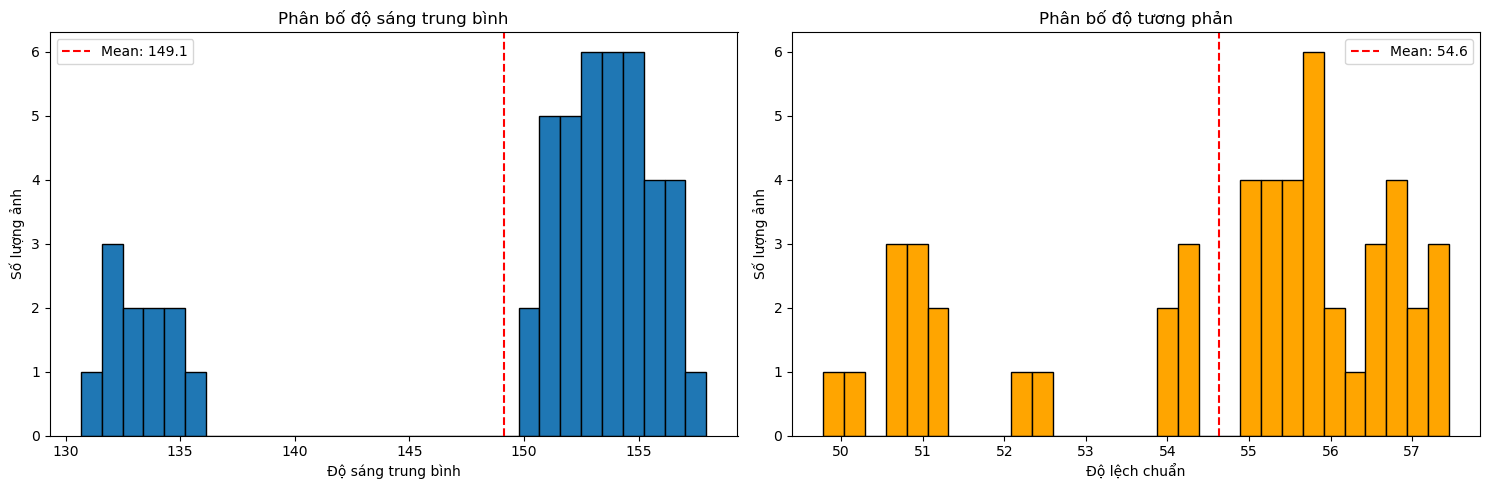

In [4]:
# Lấy mẫu để phân tích (tránh load hết vào RAM)
sample_size = min(50, len(image_files))
sample_for_analysis = np.random.choice(len(image_files), sample_size, replace=False)

mean_intensities = []
std_intensities = []

for idx in tqdm(sample_for_analysis, desc="Phân tích ảnh"):
    img = np.array(Image.open(image_files[idx]))
    mean_intensities.append(img.mean())
    std_intensities.append(img.std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(mean_intensities, bins=30, edgecolor='black')
ax1.set_xlabel('Độ sáng trung bình')
ax1.set_ylabel('Số lượng ảnh')
ax1.set_title('Phân bố độ sáng trung bình')
ax1.axvline(np.mean(mean_intensities), color='red', linestyle='--', label=f'Mean: {np.mean(mean_intensities):.1f}')
ax1.legend()

ax2.hist(std_intensities, bins=30, edgecolor='black', color='orange')
ax2.set_xlabel('Độ lệch chuẩn')
ax2.set_ylabel('Số lượng ảnh')
ax2.set_title('Phân bố độ tương phản')
ax2.axvline(np.mean(std_intensities), color='red', linestyle='--', label=f'Mean: {np.mean(std_intensities):.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Chọn ảnh đại diện để gán nhãn

Chiến lược: Chọn ảnh từ các phần khác nhau của dataset để đảm bảo tính đa dạng

In [5]:
# Số lượng ảnh cần gán nhãn (khuyến nghị 30-50 ảnh)
num_to_annotate = 40

# Chiến lược 1: Chọn đều từ đầu đến cuối video
step = len(image_files) // num_to_annotate
selected_indices_uniform = list(range(0, len(image_files), step))[:num_to_annotate]

# Chiến lược 2: Thêm một số ảnh ngẫu nhiên
remaining = num_to_annotate - len(selected_indices_uniform)
if remaining > 0:
    available = list(set(range(len(image_files))) - set(selected_indices_uniform))
    selected_indices_random = np.random.choice(available, remaining, replace=False)
    selected_indices = sorted(list(selected_indices_uniform) + list(selected_indices_random))
else:
    selected_indices = selected_indices_uniform

selected_files = [image_files[i] for i in selected_indices]

print(f"Đã chọn {len(selected_files)} ảnh để gán nhãn:")
for i, f in enumerate(selected_files[:10]):
    print(f"  {i+1}. {f.name}")
if len(selected_files) > 10:
    print(f"  ... và {len(selected_files)-10} ảnh khác")

Đã chọn 40 ảnh để gán nhãn:
  1. frame_0001.png
  2. frame_0023.png
  3. frame_0045.png
  4. frame_0067.png
  5. frame_0089.png
  6. frame_0111.png
  7. frame_0133.png
  8. frame_0155.png
  9. frame_0177.png
  10. frame_0199.png
  ... và 30 ảnh khác


## 5. Tạo cấu trúc thư mục cho dataset

In [6]:
# Tạo cấu trúc thư mục
dataset_dir = Path('my_dataset')
to_annotate_dir = dataset_dir / 'to_annotate' / 'images'

# Tạo thư mục nếu chưa có
to_annotate_dir.mkdir(parents=True, exist_ok=True)

print(f"Tạo thư mục: {to_annotate_dir}")

# Copy ảnh đã chọn vào thư mục to_annotate
for img_file in tqdm(selected_files, desc="Copy ảnh"):
    dest = to_annotate_dir / img_file.name
    if not dest.exists():
        shutil.copy2(img_file, dest)

print(f"\n✅ Đã copy {len(selected_files)} ảnh vào {to_annotate_dir}")
print(f"\n📝 BƯỚC TIẾP THEO:")
print(f"   1. Mở thư mục: {to_annotate_dir.absolute()}")
print(f"   2. Sử dụng công cụ gán nhãn (Fiji/QuPath/Napari) để tạo masks")
print(f"   3. Lưu masks vào: {dataset_dir / 'to_annotate' / 'masks'}")
print(f"   4. Sau khi hoàn thành, chạy notebook tiếp theo")

Tạo thư mục: my_dataset\to_annotate\images


Copy ảnh: 100%|██████████| 40/40 [00:00<00:00, 371.87it/s]


✅ Đã copy 40 ảnh vào my_dataset\to_annotate\images

📝 BƯỚC TIẾP THEO:
   1. Mở thư mục: c:\Users\pc\OneDrive\Documents\stardist\my_dataset\to_annotate\images
   2. Sử dụng công cụ gán nhãn (Fiji/QuPath/Napari) để tạo masks
   3. Lưu masks vào: my_dataset\to_annotate\masks
   4. Sau khi hoàn thành, chạy notebook tiếp theo


## 6. (Sau khi gán nhãn xong) Chia train/validation

In [4]:
# CHỈ CHẠY CELL NÀY SAU KHI BẠN ĐÃ GÁN NHÃN XONG!

# Định nghĩa lại các biến cần thiết
dataset_dir = Path('my_dataset')
to_annotate_dir = dataset_dir / 'to_annotate' / 'images'

# Kiểm tra xem đã có masks chưa
masks_dir = dataset_dir / 'to_annotate' / 'masks'
if not masks_dir.exists():
    print("⚠️ Chưa có thư mục masks! Hãy gán nhãn trước.")
else:
    mask_files = sorted(masks_dir.glob('*.png')) + sorted(masks_dir.glob('*.tif'))
    image_files_annotated = sorted(to_annotate_dir.glob('*.png'))
    
    print(f"Số ảnh gốc: {len(image_files_annotated)}")
    print(f"Số masks: {len(mask_files)}")
    
    if len(mask_files) == 0:
        print("⚠️ Chưa có masks! Hãy gán nhãn trước.")
    elif len(mask_files) != len(image_files_annotated):
        print(f"⚠️ CẢNH BÁO: Số lượng masks ({len(mask_files)}) không khớp với số ảnh ({len(image_files_annotated)})")
    else:
        # Chia train/val với tỷ lệ 75/25
        val_ratio = 0.25
        num_val = int(len(image_files_annotated) * val_ratio)
        num_train = len(image_files_annotated) - num_val
        
        # Shuffle và chia
        indices = np.random.permutation(len(image_files_annotated))
        train_indices = indices[:num_train]
        val_indices = indices[num_train:]
        
        # Tạo thư mục train/val
        train_img_dir = dataset_dir / 'train' / 'images'
        train_mask_dir = dataset_dir / 'train' / 'masks'
        val_img_dir = dataset_dir / 'val' / 'images'
        val_mask_dir = dataset_dir / 'val' / 'masks'
        
        for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
            d.mkdir(parents=True, exist_ok=True)
        
        # Copy files
        for idx in tqdm(train_indices, desc="Copy train set"):
            img_file = image_files_annotated[idx]
            mask_file = masks_dir / img_file.name
            
            shutil.copy2(img_file, train_img_dir / img_file.name)
            if mask_file.exists():
                shutil.copy2(mask_file, train_mask_dir / mask_file.name)
        
        for idx in tqdm(val_indices, desc="Copy validation set"):
            img_file = image_files_annotated[idx]
            mask_file = masks_dir / img_file.name
            
            shutil.copy2(img_file, val_img_dir / img_file.name)
            if mask_file.exists():
                shutil.copy2(mask_file, val_mask_dir / mask_file.name)
        
        print(f"\n✅ Đã chia dataset:")
        print(f"   Training: {num_train} ảnh")
        print(f"   Validation: {num_val} ảnh")
        print(f"\n📁 Cấu trúc thư mục:")
        print(f"   {train_img_dir}")
        print(f"   {train_mask_dir}")
        print(f"   {val_img_dir}")
        print(f"   {val_mask_dir}")
        print(f"\n🎯 Sẵn sàng để training! Mở notebook: 1_training_my_data.ipynb")

Số ảnh gốc: 40
Số masks: 40


Copy validation set: 100%|██████████| 10/10 [00:00<00:00, 219.39it/s]


✅ Đã chia dataset:
   Training: 30 ảnh
   Validation: 10 ảnh

📁 Cấu trúc thư mục:
   my_dataset\train\images
   my_dataset\train\masks
   my_dataset\val\images
   my_dataset\val\masks

🎯 Sẵn sàng để training! Mở notebook: 1_training_my_data.ipynb


## 7. Kiểm tra chất lượng annotations (sau khi gán nhãn)

frame_0441.png: 139 objects, values: [0 1 2 3 4 5 6 7 8 9]...
frame_0463.png: 120 objects, values: [0 1 2 3 4 5 6 7 8 9]...
frame_0331.png: 104 objects, values: [0 1 2 3 4 5 6 7 8 9]...
frame_0221.png: 135 objects, values: [0 1 2 3 4 5 6 7 8 9]...
frame_0551.png: 139 objects, values: [0 1 2 3 4 5 6 7 8 9]...
frame_0155.png: 169 objects, values: [0 1 2 3 4 5 6 7 8 9]...


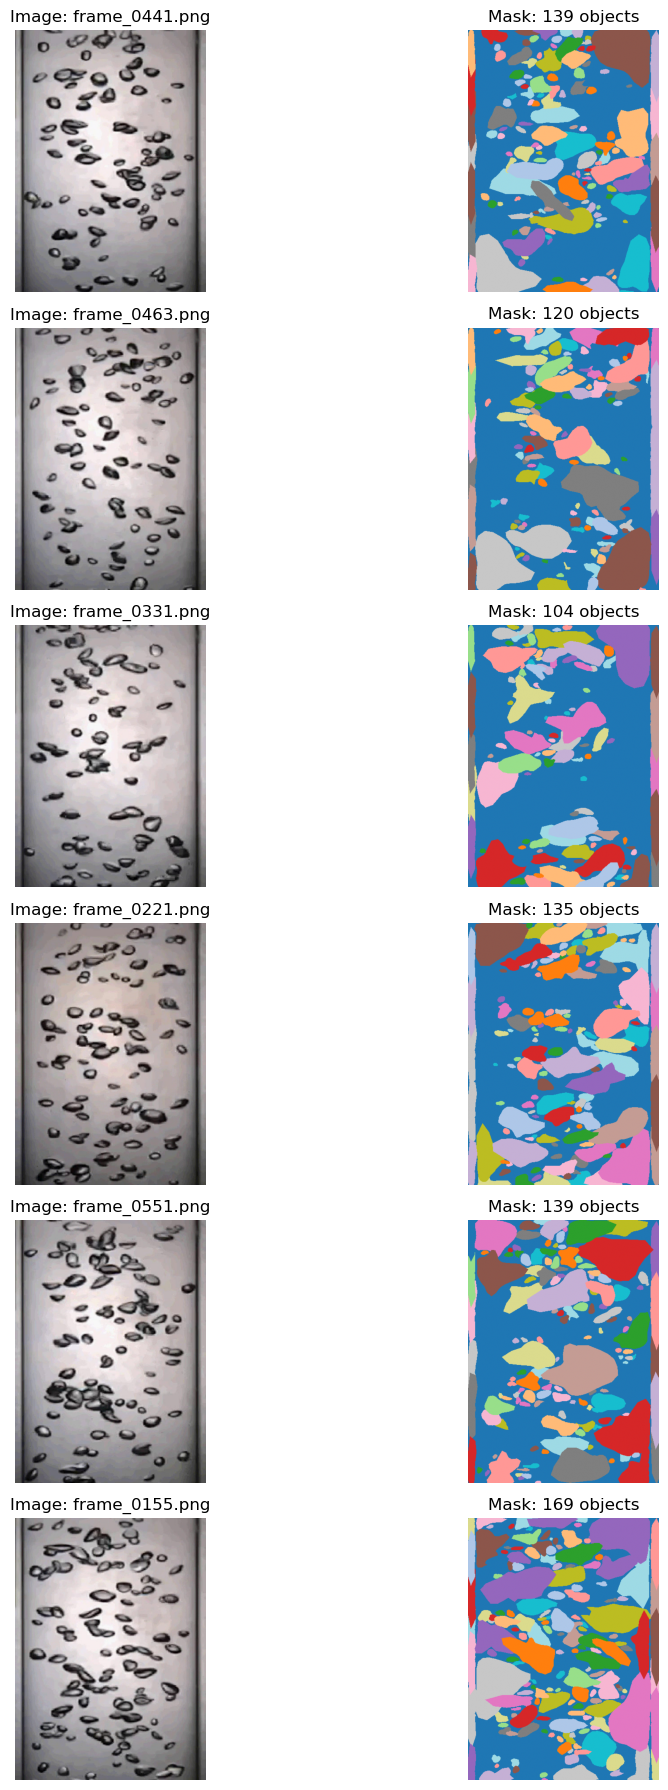


=== KIỂM TRA CHẤT LƯỢNG ===
✅ Masks phải là ảnh label (mỗi object có 1 giá trị riêng)
✅ Background phải là 0
✅ Các objects không được chạm nhau (có khoảng cách)
✅ Tên file ảnh và mask phải giống nhau


In [5]:
# Kiểm tra một số masks để đảm bảo chất lượng
masks_dir = dataset_dir / 'to_annotate' / 'masks'

if masks_dir.exists():
    mask_files = sorted(list(masks_dir.glob('*.png')) + list(masks_dir.glob('*.tif')))
    
    if len(mask_files) > 0:
        # Xem 6 cặp ảnh-mask ngẫu nhiên
        num_samples = min(6, len(mask_files))
        sample_masks = np.random.choice(mask_files, num_samples, replace=False)
        
        fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for idx, mask_path in enumerate(sample_masks):
            # Load image và mask
            img_path = to_annotate_dir / mask_path.name
            
            if img_path.exists():
                img = np.array(Image.open(img_path))
                mask = np.array(Image.open(mask_path))
                
                # Hiển thị
                axes[idx, 0].imshow(img, cmap='gray' if img.ndim == 2 else None)
                axes[idx, 0].set_title(f"Image: {img_path.name}")
                axes[idx, 0].axis('off')
                
                axes[idx, 1].imshow(mask, cmap='tab20')
                axes[idx, 1].set_title(f"Mask: {np.unique(mask).size-1} objects")
                axes[idx, 1].axis('off')
                
                # In thông tin
                print(f"{mask_path.name}: {np.unique(mask).size-1} objects, values: {np.unique(mask)[:10]}...")
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n=== KIỂM TRA CHẤT LƯỢNG ===")
        print(f"✅ Masks phải là ảnh label (mỗi object có 1 giá trị riêng)")
        print(f"✅ Background phải là 0")
        print(f"✅ Các objects không được chạm nhau (có khoảng cách)")
        print(f"✅ Tên file ảnh và mask phải giống nhau")
    else:
        print("⚠️ Chưa có masks trong thư mục!")
else:
    print("⚠️ Chưa có thư mục masks! Hãy tạo thư mục và gán nhãn.")

---
## 📝 TÓM TẮT CÁC BƯỚC

1. ✅ Đã xem và phân tích 886 frames
2. ✅ Đã chọn ~40 ảnh đại diện và copy vào `my_dataset/to_annotate/images/`
3. ⏳ **TIẾP THEO**: Gán nhãn cho các ảnh này bằng công cụ annotation
4. ⏳ Sau khi gán nhãn xong, chạy lại cell chia train/val
5. ⏳ Chạy notebook training

## 🛠️ CÔNG CỤ GÁN NHÃN KHUYẾN NGHỊ

### Lựa chọn 1: Fiji/ImageJ (ĐƠN GIẢN NHẤT)
```
1. Download Fiji từ https://fiji.sc/
2. Mở ảnh trong Fiji
3. Dùng tool vẽ (Polygon/Freehand) để khoanh vùng objects
4. Thêm vào ROI Manager
5. Chuyển ROIs thành label image: Analyze > Tools > ROI Manager > More > Labels
6. Save as 16-bit TIFF
```

### Lựa chọn 2: Napari + plugin
```bash
pip install napari[all] napari-segment-blobs-and-things-with-membranes
napari
```

### Lựa chọn 3: QuPath (MẠNH MẼ)
- Download từ https://qupath.github.io/
- Tốt cho ảnh sinh học/y học